In [8]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("emails.csv")

df_spam = df[df['spam'] == 1].head(500)
df_ham = df[df['spam'] == 0].head(500)
df = pd.concat([df_spam, df_ham]).sample(frac=1, random_state=42).reset_index(drop=True)

# Data Cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

df['cleaned_text'] = df['text'].apply(clean_text)

In [9]:
df['cleaned_text']

0      [subject, ljm, update, vince, stinson, came, b...
1      [subject, software, license, karla, august, va...
2      [subject, impending, visit, vince, would, frid...
3      [subject, quantitative, position, vince, happe...
4      [subject, ready, get, hello, viagra, 1, med, s...
                             ...                        
995    [subject, free, 1, week, dvd, downloads, happy...
996    [subject, iso, 8859, 1, q, automated, reply, a...
997    [subject, congratulations, extra, well, deserv...
998    [subject, cry, help, dear, friend, mrs, sese, ...
999    [subject, legal, operating, systems, summer, s...
Name: cleaned_text, Length: 1000, dtype: object

In [16]:
words = list(model.wv.key_to_index.keys())[:100]  # Select 100 words for visualization
word_vectors = np.array([model.wv[word] for word in words])
word_vectors

array([[-0.4401835 ,  0.85500455,  0.6204501 , ..., -1.7774093 ,
         1.1870213 , -0.44406685],
       [-0.34070024,  0.70042145,  0.3795745 , ..., -1.2567916 ,
         0.87064004, -0.44024912],
       [-0.6907246 ,  1.5083872 ,  0.36038375, ..., -2.5357857 ,
         1.6025659 , -0.68680197],
       ...,
       [-0.33215275,  0.567721  ,  0.08705603, ..., -0.47689098,
        -0.10008197,  0.33946636],
       [-0.26616812,  0.56767905,  0.14913547, ..., -0.5988792 ,
         0.28106657,  0.05546752],
       [-0.32206297,  1.2695612 ,  0.02407414, ..., -1.0056083 ,
         1.5701754 , -0.11744794]], dtype=float32)

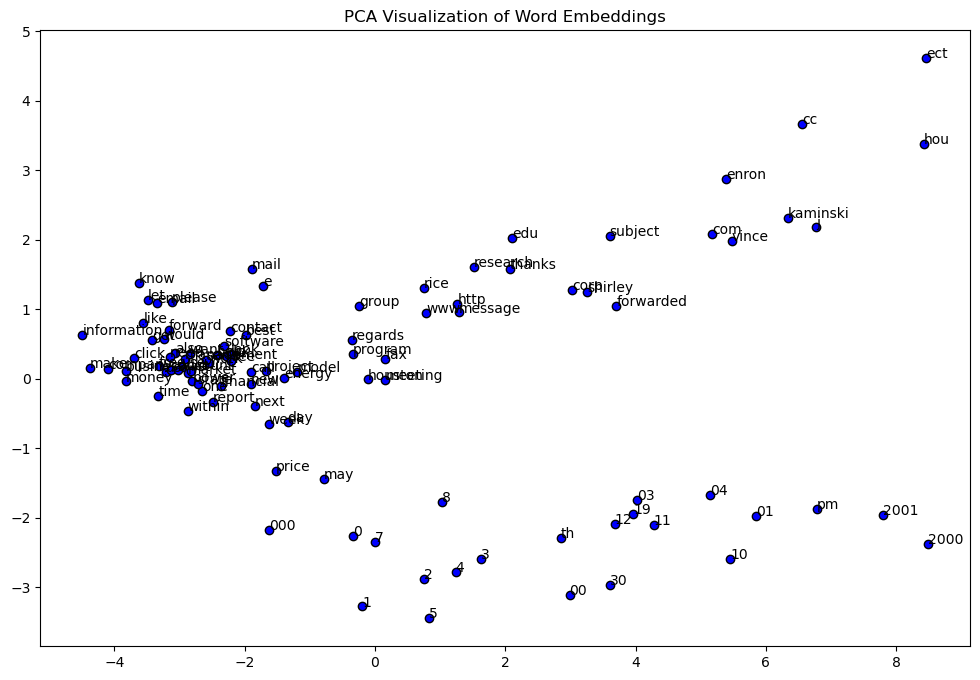

Spam Classification Accuracy: 0.93
Sample Email Prediction (Spam Example): Spam
Sample Email Prediction (Non-Spam Example): Not Spam


In [7]:

# Creating Corpus
corpus = df['cleaned_text'].tolist()

# Generate Word2Vec Model
model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4)

# Visualizing Word Embeddings
def visualize_embeddings(model):
    words = list(model.wv.key_to_index.keys())[:100]  # Select 100 words for visualization
    word_vectors = np.array([model.wv[word] for word in words])
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(word_vectors)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], edgecolors='k', c='blue')
    for i, word in enumerate(words):
        plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.title("PCA Visualization of Word Embeddings")
    plt.show()

visualize_embeddings(model)

# Creating Feature Vectors
def get_email_vector(email_tokens, model):
    vectors = [model.wv[word] for word in email_tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

df['vector'] = df['cleaned_text'].apply(lambda x: get_email_vector(x, model))
X = np.vstack(df['vector'].values)
y = df['spam']

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Spam Classification Accuracy: {accuracy:.2f}")

# Sample Input and Prediction
def predict_email(text, model, clf):
    cleaned_tokens = clean_text(text)
    email_vector = get_email_vector(cleaned_tokens, model).reshape(1, -1)
    prediction = clf.predict(email_vector)[0]
    return "Spam" if prediction == 1 else "Not Spam"

sample_email_spam = "Congratulations! You've won a free lottery. Click here to claim your prize."
print(f"Sample Email Prediction (Spam Example): {predict_email(sample_email_spam, model, clf)}")

sample_email_non_spam = "Hey, are we still on for the meeting tomorrow at 10 AM? Let me know."
print(f"Sample Email Prediction (Non-Spam Example): {predict_email(sample_email_non_spam, model, clf)}")

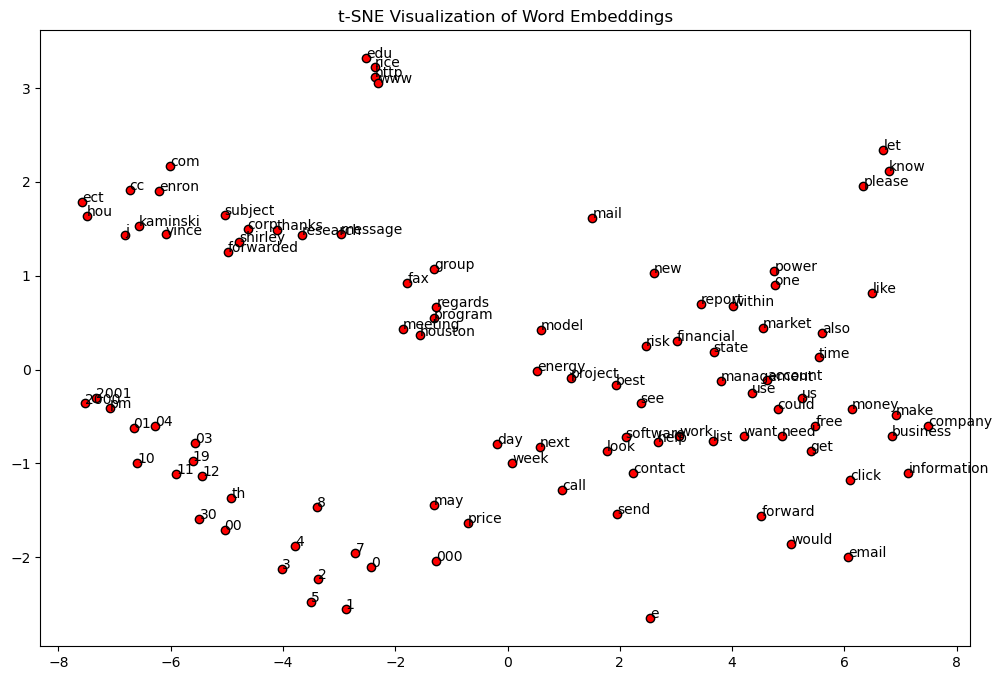

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_embeddings_tsne(model):
    words = list(model.wv.key_to_index.keys())[:100]  # Select 100 words for visualization
    word_vectors = np.array([model.wv[word] for word in words])

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_vectors = tsne.fit_transform(word_vectors)

    # Plot the t-SNE visualization
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], edgecolors='k', c='red')

    for i, word in enumerate(words):
        plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))

    plt.title("t-SNE Visualization of Word Embeddings")
    plt.show()

visualize_embeddings_tsne(model)